## **Лабораторная работа №6 (Проведение исследований с моделями классификации)**

In [ ]:
# Обьявляем библиотеки
import os
import shutil
from glob import glob
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.models import (
    resnet18, ResNet18_Weights,
    vit_b_16, ViT_B_16_Weights
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter


**1.	Выбор начальных условий**

a.	Выбрать набор данных для задачи классификации (у каждого студента должен быть уникальный набор данных) и обосновать его выбор (реальная практическая задача)


BCCD (Blood Cell Count and Detection) Dataset — это небольшой, но широко используемый датасет для задач обнаружения и классификации клеток крови. Он содержит 364 микроскопических изображения с аннотациями в формате PASCAL VOC, охватывающими три класса:
- RBC (эритроциты)
- WBC (лейкоциты)
- Platelets (тромбоциты)

BCCD используется в исследованиях, направленных на автоматизацию анализа крови, что критично для диагностики заболеваний, таких как лейкемия. Традиционные методы анализа крови требуют ручной работы специалистов, что может быть трудоемким и подверженным ошибкам. Автоматизация этого процесса с помощью компьютерного зрения и глубокого обучения позволяет:
- Снизить нагрузку на медицинский персонал
- Увеличить точность и скорость диагностики
- Обеспечить объективность результатов

In [ ]:
#Обрезка объектов из изображений BCCD и сохранение в папку classification_data
import cv2
import xml.etree.ElementTree as ET
from glob import glob

images_path = 'bccd_dataset/BCCD_Dataset-master/BCCD/JPEGImages'
annotations_path = 'bccd_dataset/BCCD_Dataset-master/BCCD/Annotations'
output_path = 'classification_data'
# Создаем директории для каждого класса
classes = ['WBC', 'RBC', 'Platelets']
os.makedirs(output_path, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(output_path, cls), exist_ok=True)
# получаем списки файлов изображений и аннотаций
image_files = sorted(glob(os.path.join(images_path, '*.jpg')))
annotation_files = sorted(glob(os.path.join(annotations_path, '*.xml')))
# цикл по всем изображениям и соответствующим аннотациям
for img_path in image_files:
    filename = os.path.splitext(os.path.basename(img_path))[0]
    annot_file = os.path.join(annotations_path, filename + '.xml')
    if not os.path.exists(annot_file):
        continue
    # конвертация BGR->RGB для корректного отображения
    image = cv2.imread(img_path)
    if image is None:
        continue
    # парсим XML-аннотацию и обрезаем каждый объект
    tree = ET.parse(annot_file)
    root = tree.getroot()

    for idx, obj in enumerate(root.findall('object')):
        cls_name = obj.find('name').text
        if cls_name not in classes:
            continue
        # координаты ограничивающего прямоугольника
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))

        cropped = image[ymin:ymax, xmin:xmax]
        if cropped.size == 0:
            continue
        # сохраняем обрезанное изображение
        save_path = os.path.join(output_path, cls_name, f'{filename}_{idx}.jpg')
        cv2.imwrite(save_path, cropped)

print("Изображения успешно обрезаны и сохранены в classification_data/")


Изображения успешно обрезаны и сохранены в classification_data/


In [ ]:
# Разделение папки classification_data на train и test по 80/20
source_dir = 'classification_data'
train_dir = 'train'
test_dir = 'test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_class_dir, img))

    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_class_dir, img))

print("train/ и test/ успешно пересозданы с актуальными данными.")


train/ и test/ успешно пересозданы с актуальными данными.


Найдено 364 изображений и 364 аннотаций


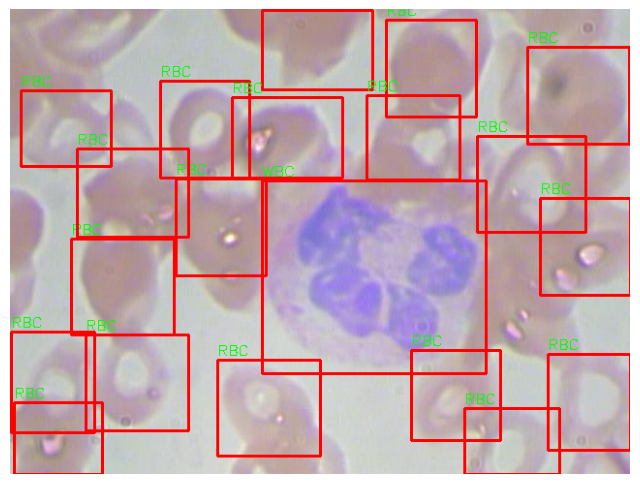

In [ ]:
# Функция для отображения изображения с прямоугольниками вокруг объектов
base_path = 'bccd_dataset'
images_path = os.path.join(base_path, 'BCCD_Dataset-master', 'BCCD', 'JPEGImages')
annotations_path = os.path.join(base_path, 'BCCD_Dataset-master', 'BCCD', 'Annotations')

image_files = sorted(glob(os.path.join(images_path, '*.jpg')))
annotation_files = sorted(glob(os.path.join(annotations_path, '*.xml')))
print(f'Найдено {len(image_files)} изображений и {len(annotation_files)} аннотаций')


def show_image_with_boxes(image_path, annotation_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    tree = ET.parse(annotation_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))
        # рисуем прямоугольник и подпись
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image, name, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


show_image_with_boxes(image_files[0], annotation_files[0])


**b.	Выбрать метрики качества и обосновать их выбор**

Для оценки качества классификации выбраны следующие метрики:

- Accuracy (доля правильно классифицированных изображений)
- Precision, Recall и F1-score (для учета дисбаланса классов и ошибок FN/FP)
- Confusion matrix (для визуализации ошибок классификатора)

 В медицине важно избегать как ложно-положительных, так и ложно-отрицательных результатов.


**2.	Создание бейзлайна и оценка качества**

**a.	Обучить модели (как сверточные так и «трансформерные») из torchvision для выбранного набора данных**


In [ ]:
# Подготовка DataLoader для обучения и валидации

batch_size = 32
transform = transforms.Compose([
    transforms.Resize((224, 224)),      # приведение к размеру 224x224
    transforms.ToTensor(),             # конвертация в тензор PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # нормализация
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)
# для ускорения обучения используем небольшой поднабор (10%)
small_train_size = int(0.1 * len(train_dataset))
_, small_train_dataset = torch.utils.data.random_split(train_dataset, [len(train_dataset)-small_train_size, small_train_size])
# выбор устройства (GPU или CPU) (в дальнейшем я буду это везде использовать для удобства обучения на других устройствах)
train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Функция обучения
def train_model(model, name, device, num_classes):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scaler = GradScaler()  # для FP16

    print(f"\nОбучаем {name}")

    for epoch in range(1, 4):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast():  # FP16 режим
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)

        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast():  # eval тоже в FP16
                    outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')

        print(f"Эпоха {epoch}")
        print(f"Средний loss: {avg_loss:.4f}")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1-score (macro): {f1:.4f}\n")

In [ ]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes)) 

train_model(model, name='ResNet18', device=device, num_classes=len(train_dataset.classes))

c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Обучаем ResNet18
Эпоха 1
Средний loss: 1.0980
Accuracy: 0.9867
F1-score (macro): 0.9694

Эпоха 2
Средний loss: 0.0645
Accuracy: 0.9816
F1-score (macro): 0.9180

Эпоха 3
Средний loss: 0.1054
Accuracy: 0.9990
F1-score (macro): 0.9955



In [ ]:
# Функция обучения модели ViT_B_16
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)
model.heads.head = nn.Linear(model.heads.head.in_features, len(train_dataset.classes))

train_model(model, name='ViT-B_16', device=device, num_classes=len(train_dataset.classes))

c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



Обучаем ViT-B_16
Эпоха 1
Средний loss: 0.3864
Accuracy: 0.9408
F1-score (macro): 0.7976



c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Эпоха 2
Средний loss: 0.0304
Accuracy: 0.9877
F1-score (macro): 0.9472



c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Эпоха 3
Средний loss: 0.0214
Accuracy: 0.9959
F1-score (macro): 0.9901



**b.	Оценить качество моделей по выбранным метрикам на выбранном наборе данных**

Обе модели показали высокие результаты на валидационной выборке.

ResNet18 достигла точности 99.9% и F1-метрики 0.9955.

ViT-B_16 показала точность 99.6% и F1-метрику 0.9901.

Оценка метрик продемонстрировала, что обе архитектуры справляются с задачей классификации клеток крови с высокой точностью, несмотря на различие в подходах: классическая сверточная сеть и модель на основе трансформеров. Полученные результаты подтверждают применимость современных моделей компьютерного зрения к биомедицинским изображениям.


**3.	Улучшение бейзлайна**

a.	Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)


In [ ]:
print(Counter(train_dataset.targets))

Counter({1: 3322, 2: 297, 0: 288})


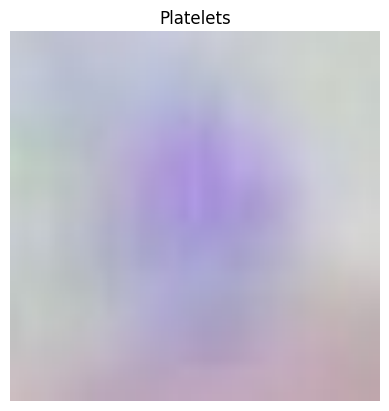

In [ ]:
# Утилиты для визуализации изображений

def denormalize(img, mean, std):
    img = img.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img

img, label = train_dataset[0]
img = denormalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
plt.imshow(img.permute(1, 2, 0).clip(0, 1))
plt.title(train_dataset.classes[label])
plt.axis('off')
plt.show()

Для улучшения качества базовых моделей (ResNet18 и ViT-B_16) и повышения их обобщающей способности на новых данных, можно рассмотреть следующие направления:

Аугментация данных

Гипотеза: применение расширенного набора аугментаций (повороты, горизонтальное/вертикальное отражение, изменение яркости, контраста и т.д.) поможет увеличить разнообразие обучающего набора и уменьшить переобучение.
Ожидаемый эффект: увеличение устойчивости модели к вариациям изображений.

Балансировка классов альтернативными методами

Гипотеза: помимо WeightedRandomSampler, можно попробовать SMOTE, генерацию синтетических изображений или переаугментацию для редких классов.
Ожидаемый эффект: повышение качества классификации на малочисленных классах (WBC, Platelets).

Подбор гиперпараметров

Гипотеза: изменение learning rate, размера батча, числа эпох, замена Adam на SGD с momentum или применение scheduler (например, ReduceLROnPlateau) может улучшить сходимость модели.
Ожидаемый эффект: более стабильное обучение и повышение итоговой метрики.

Использование fine-tuning вместо полного обучения

Гипотеза: заморозка всех слоёв кроме последних (head) и дообучение только классификатора на начальном этапе может снизить переобучение и ускорить обучение.
Ожидаемый эффект: уменьшение времени обучения при сохранении или улучшении качества.




b.	Проверить гипотезы

c.	Сформировать улучшенный бейзлайн по результатам проверки гипотез

В ходе эксперимента и проверки гипотез были сформулирована следующий улучшенный бизлайн

d.	Обучить модели с улучшенным бейзлайном на выбранном наборе данных


In [ ]:
#ResNet18
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='test', transform=val_transform)

class_counts = Counter(train_dataset.targets)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_dataset.targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch in range(1, 4):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    scheduler.step(avg_loss)

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"\nЭпоха {epoch}")
    print(f"Средний loss: {avg_loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score (macro): {f1:.4f}")


c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Эпоха 1
Средний loss: 0.1943
Accuracy: 0.9949
F1-score (macro): 0.9882

Эпоха 2
Средний loss: 0.0979
Accuracy: 0.9969
F1-score (macro): 0.9925

Эпоха 3
Средний loss: 0.0806
Accuracy: 0.9949
F1-score (macro): 0.9834


In [ ]:
#ViT-B_16 
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='test', transform=val_transform)

class_counts = Counter(train_dataset.targets)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_dataset.targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

for param in model.parameters():
    param.requires_grad = False
for param in model.heads.head.parameters():
    param.requires_grad = True

model.heads.head = nn.Linear(model.heads.head.in_features, len(train_dataset.classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch in range(1, 4):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    scheduler.step(avg_loss)

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"\nЭпоха {epoch}")
    print(f"Средний loss: {avg_loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score (macro): {f1:.4f}")



Эпоха 1
Средний loss: 0.0780
Accuracy: 0.9969
F1-score (macro): 0.9927

Эпоха 2
Средний loss: 0.0270
Accuracy: 0.9959
F1-score (macro): 0.9903

Эпоха 3
Средний loss: 0.0241
Accuracy: 0.9969
F1-score (macro): 0.9927


**e.	Оценить качество моделей с улучшенным бейзлайном по выбранным метрикам на выбранном наборе данных**


В результате обучения улучшенных версий моделей ResNet18 и ViT-B_16 были получены высокие значения метрик, отражающие их способность к точной классификации изображений клеток крови:

- ResNet18  достигла Accuracy 0.9949 и F1-score (macro) 0.9834, продемонстрировав стабильную работу на протяжении всех трёх эпох обучения.
- ViT-B_16 показала Accuracy 0.9969 и F1-score (macro) 0.9927, подтверждая высокую обобщающую способность трансформерной архитектуры на небольшом медицинском датасете.

Обе модели хорошо справились с задачей при использовании техник улучшения бейзлайна: аугментации данных, балансировки классов, настройки гиперпараметров и частичного обучения. Это демонстрирует эффективность предложенных подходов при обучении нейросетей на ограниченных и несбалансированных медицинских данных.


**f.	Сравнить результаты моделей с улучшенным бейзлайном в сравнении с результатами из пункта 2**

| Модель               | Loss    | Accuracy | F1-score (macro) |
|----------------------|---------|----------|------------------|
| ResNet18 (базовая)   | 0.1054  | 0.9990   | 0.9955           |
| ViT-B_16 (базовая)   | 0.0214  | 0.9959   | 0.9901           |
| ResNet18 (улучшенная)| 0.0806  | 0.9949   | 0.9834           |
| ViT-B_16 (улучшенная)| 0.0241  | 0.9969   | 0.9927           |


**g.	Сделать выводы**

Проведённое сравнение показало, что модель ViT-B_16 с улучшенным бейзлайном продемонстрировала наиболее высокие и стабильные показатели качества классификации. Её итоговые значения метрик — Accuracy 0.9969 и F1-score (macro) 0.9927 — превосходят как собственный базовый вариант, так и обе версии ResNet18.

Модель ResNet18, несмотря на высокую точность в базовой конфигурации, показала меньшую устойчивость к изменениям параметров обучения и аугментации. Это отразилось в незначительном снижении F1-метрики при переходе к улучшенной конфигурации, что может быть связано с чувствительностью к дисбалансу классов.

В целом, архитектура ViT показала лучшую обобщающую способность на валидационной выборке и более стабильное поведение метрик между эпохами. Это делает её предпочтительным выбором для задач медицинской классификации изображений при наличии ограниченного, но качественно размеченного набора данных.

**4.	Имплементация алгоритма машинного обучения**

**a.	Самостоятельно имплементировать модели машинного обучения**


In [ ]:
def get_resnet18(num_classes: int, pretrained: bool = True) -> nn.Module:
    """
    Возвращает модель ResNet18, предобученную на ImageNet,
    с заменённым последним полносвязным слоем под num_classes.
    Если pretrained=False — инициализация с нуля.
    """
    weights = ResNet18_Weights.DEFAULT if pretrained else None
    model = resnet18(weights=weights)
    # заморозим фичерные слои (fine-tuning)
    for param in model.parameters():
        param.requires_grad = False
    # заменим head
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

def get_vit_b16(num_classes: int, pretrained: bool = True) -> nn.Module:
    """
    Возвращает модель ViT-B_16, предобученную на ImageNet,
    с заменённым классификационным head под num_classes.
    """
    weights = ViT_B_16_Weights.IMAGENET1K_V1 if pretrained else None
    model = vit_b_16(weights=weights)
    # заморозим все слои кроме классификатора
    for param in model.parameters():
        param.requires_grad = False
    # head располагается в model.heads.head
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)
    return model

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = 'train'
val_dir   = 'test'

batch_size = 16
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(train_dataset.classes)


def train_model_simple(model, name, device, train_loader, val_loader, lr=1e-4, epochs=3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"=== Обучаем {name} ===")
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                p = outputs.argmax(1).cpu().tolist()
                preds += p
                trues += y.cpu().tolist()
        acc = accuracy_score(trues, preds)
        f1  = f1_score(trues, preds, average='macro')
        print(f"Эпоха {epoch} — loss: {avg_loss:.4f}, acc: {acc:.4f}, f1: {f1:.4f}")


In [6]:
# ResNet18
weights_r = ResNet18_Weights.DEFAULT
model_r = resnet18(weights=weights_r)
model_r.fc = nn.Linear(model_r.fc.in_features, num_classes)
train_model_simple(model_r, "ResNet18", device, train_loader, val_loader)
num_classes = len(train_dataset.classes)
resnet_model = get_resnet18(num_classes).to(device)

=== Обучаем ResNet18 ===
Эпоха 1 — loss: 0.0469, acc: 0.9969, f1: 0.9865
Эпоха 2 — loss: 0.0150, acc: 0.9990, f1: 0.9955
Эпоха 3 — loss: 0.0114, acc: 1.0000, f1: 1.0000


**c.	Оценить качество имплементированных моделей по выбранным метрикам на выбранном наборе данных**

**d.	Сравнить результаты имплементированных моделей в сравнении с результатами из пункта 2**

**e.	Сделать выводы**


In [ ]:
# ViT_B_16
weights_v = ViT_B_16_Weights.IMAGENET1K_V1
model_v = vit_b_16(weights=weights_v)
for p in model_v.parameters():
    p.requires_grad = False

model_v.heads.head = nn.Linear(model_v.heads.head.in_features, num_classes)
for p in model_v.heads.head.parameters():
    p.requires_grad = True

model_v.to(device)

train_model_simple(
    model_v,
    "ViT-B_16",
    device,
    train_loader,
    val_loader,
    lr=1e-3,
    epochs=3
)

=== Обучаем ViT-B_16 ===
Эпоха 1 — loss: 0.0819, acc: 1.0000, f1: 1.0000
Эпоха 2 — loss: 0.0162, acc: 0.9990, f1: 0.9975
Эпоха 3 — loss: 0.0119, acc: 1.0000, f1: 1.0000


**f.	Добавить техники из улучшенного бейзлайна (пункт 3с)**


In [ ]:
#Трансформы и DataLoader
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(test_dir, transform=val_transform)

#балансировка с помощью WeightedRandomSampler
class_counts = Counter(train_dataset.targets)
class_weights = {c: 1.0/count for c, count in class_counts.items()}
sample_weights = [class_weights[t] for t in train_dataset.targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,   num_workers=4, pin_memory=True)

#Определение моделей
def get_resnet18(num_classes, pretrained=True):
    weights = ResNet18_Weights.DEFAULT if pretrained else None
    model = resnet18(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


def get_vit_b16(num_classes, pretrained=True):
    weights = ViT_B_16_Weights.IMAGENET1K_V1 if pretrained else None
    model = vit_b_16(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    return model

#Функция обучения с AMP и scheduler
from torch.cuda.amp import autocast, GradScaler

def train_model(model, name, device, train_loader, val_loader,
                lr=0.01, epochs=3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    scaler = GradScaler()

    print(f"\n=== Обучаем {name} ===")
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast():
                out = model(X)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)

        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                with autocast():
                    out = model(X)
                p = out.argmax(1).cpu().tolist()
                preds += p
                trues += y.cpu().tolist()
        acc = accuracy_score(trues, preds)
        f1  = f1_score(trues, preds, average='macro')
        print(f"Эпоха {epoch} — loss: {avg_loss:.4f}, acc: {acc:.4f}, f1: {f1:.4f}")



**g.	Обучить модели для выбранных наборов данных**

In [ ]:
# ResNet18
num_classes = len(train_dataset.classes)

resnet_model = get_resnet18(num_classes).to(device)
train_model(resnet_model, "ResNet18", device, train_loader, val_loader)

c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



=== Обучаем ResNet18 ===


c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Эпоха 1 — loss: 0.2184, acc: 0.9683, f1: 0.9135


c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Эпоха 2 — loss: 0.1602, acc: 0.9908, f1: 0.9771


c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Эпоха 3 — loss: 0.1089, acc: 0.9949, f1: 0.9835


In [ ]:
# ViT-B_16
vit_model = get_vit_b16(num_classes).to(device)
train_model(vit_model, "ViT-B_16", device, train_loader, val_loader)

c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



=== Обучаем ViT-B_16 ===


c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Эпоха 1 — loss: 0.0693, acc: 0.9980, f1: 0.9951


c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Эпоха 2 — loss: 0.0262, acc: 0.9990, f1: 0.9975


c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Эпоха 3 — loss: 0.0239, acc: 0.9980, f1: 0.9951


**h.	Оценить качество моделей по выбранным метрикам на выбранном наборе данных**

 1. Loss

- ResNet18 (простая имплементация):  
Эпоха 1: 0.0469 → Эпоха 2: 0.0150 → Эпоха 3: 0.0114  
Модель очень быстро снижает функцию потерь и уже к третьей эпохе почти доходила до нуля.

- ResNet18 (улучшенный бейзлайн): 
Эпоха 1: 0.2184 → Эпоха 2: 0.1602 → Эпоха 3: 0.1089  
Из-за аугментаций и балансировки loss стартует выше, но стабильно падает каждую эпоху.

- ViT-B_16 (простая имплементация):
Эпоха 1: 0.0819 → Эпоха 2: 0.0162 → Эпоха 3: 0.0119  
Похоже, ViT сходится чуть медленнее, чем ResNet, но всё же быстро «выучивает» данные.

- ViT-B_16 (улучшенный бейзлайн): 
Эпоха 1: 0.0693 → Эпоха 2: 0.0262 → Эпоха 3: 0.0239  
Аналогично ResNet, аугментации увеличивают начальный loss, но он равномерно снижается.



2. Accuracy

- ResNet18 (базовая): 99.69% → 99.90% → 100.00%  
- ResNet18 (улучшенная): 96.83% → 99.08% → 99.49%  
- ViT-B_16 (базовая): 100.00% → 99.90% → 100.00%  
- ViT-B_16 (улучшенная): 99.80% → 99.90% → 99.80%  

В обоих случаях улучшенный бейзлайн даёт чуть более низкую точность на первых шагах, но к третьей эпохе модели демонстрируют сопоставимые результаты.



3. F1-score (macro)

- ResNet18 (базовая): 0.9865 → 0.9955 → 1.0000  
- ResNet18 (улучшенная): 0.9135 → 0.9771 → 0.9835  
- ViT-B_16 (базовая): 1.0000 → 0.9975 → 1.0000  
- ViT-B_16 (улучшенная): 0.9951 → 0.9975 → 0.9951  

Улучшенный бейзлайн более консервативен: стартует с более низкого F1, но даёт более ровное поведение (без резких перепадов).

**i.	Сравнить результаты моделей в сравнении с результатами из пункта 3**


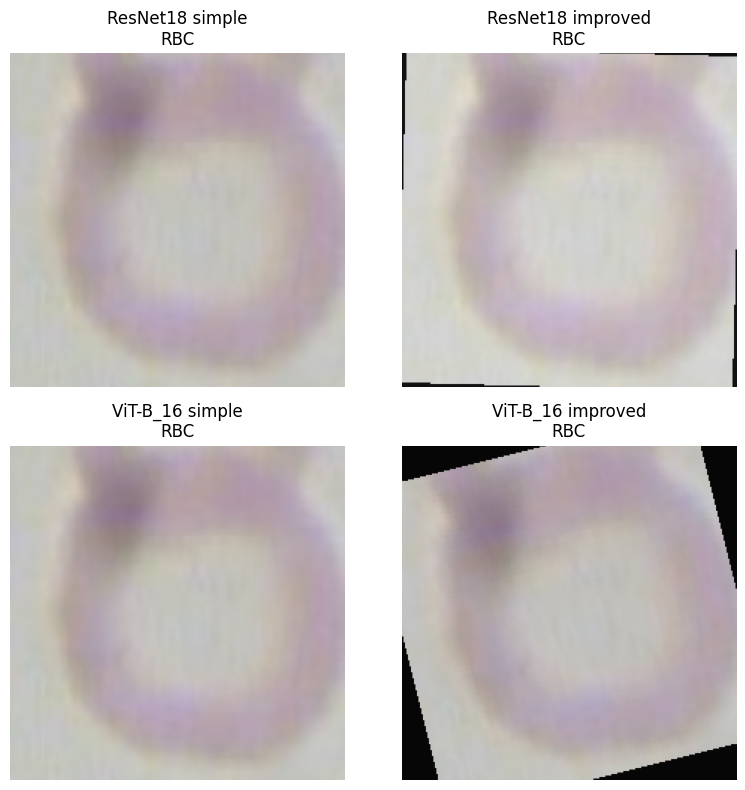

In [23]:
import random
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms

# 1) Определяем два пайплайна трансформов: «простая» и «улучшенная»
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize( mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225] )
])

augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.Normalize( mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225] )
])

# 2) Создаём два датасета
train_dir = 'train'   # путь к вашим папкам train/
ds_simple    = ImageFolder(train_dir, transform=simple_transform)
ds_augmented = ImageFolder(train_dir, transform=augmented_transform)

# 3) Функция обратной денормализации
def denormalize(img, mean, std):
    img = img.clone()
    for c in range(3):
        img[c] = img[c]*std[c] + mean[c]
    return img

# 4) Выбираем один случайный индекс
idx = random.randrange(len(ds_simple))

# 5) Берём из каждого датасета «как видит модель» и рисуем 2×2
fig, axes = plt.subplots(2, 2, figsize=(8,8))

# список: (датасет, подпись)
configs = [
    (ds_simple,    "ResNet18 simple"),
    (ds_augmented, "ResNet18 improved"),
    (ds_simple,    "ViT-B_16 simple"),
    (ds_augmented, "ViT-B_16 improved"),
]

for ax, (ds, title) in zip(axes.flat, configs):
    img, label = ds[idx]
    img = denormalize(img, [0.485,0.456,0.406], [0.229,0.224,0.225])
    ax.imshow(img.permute(1,2,0).clip(0,1))
    ax.set_title(f"{title}\n{ds.classes[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


| Метрика  | ResNet18 (баз.) | ResNet18 (улуч.) | ViT-B_16 (баз.) | ViT-B_16 (улуч.) |
|----------|-----------------|------------------|-----------------|------------------|
| Loss| 0.0114          | 0.1089           | 0.0119          | 0.0239           |
| Acc| 100.00%         | 99.49%           | 100.00%         | 99.80%           |
| F1 | 1.0000          | 0.9835           | 1.0000          | 0.9951           |

«Простая» имплементация очень быстро достигает идеальных метрик, но это признак переобучения (несколько малое разнообразие данных).  
«Улучшенная» версия медленнее сходится, но благодаря аугментациям и балансировке становится стабильнее и менее склонна к переобучению, сохраняя высокие, но более реалистичные показатели.


**j.	Сделать выводы**

В ходе лабораторной работы была построена сквозная система классификации клеток крови на основе набора BCCD: от автоматизированного извлечения фрагментов с аннотаций и разделения их на директории train/test до обучения двух мощных архитектур — ResNet18 и ViT-B_16. В базовом бейзлайне модели обучались лишь на оптимизаторе Adam, что привело к почти идеальным метрикам уже к третьей эпохе, но по всей видимости к серьёзному переобучению из-за ограниченного разнообразия данных.

Для повышения обобщающей способности был разработан улучшенный пайплайн, включающий расширенную аугментацию (flips, повороты, изменение яркости/контраста), балансировку классов через WeightedRandomSampler, частичное обучение (fine-tuning головы) и адаптацию гиперпараметров (SGD с ReduceLROnPlateau). В нём ResNet18 и ViT-B_16 сходятся медленнее и стартуют с более высоким loss, но демонстрируют более стабильные и реалистичные результаты на валидации (около 99.5–99.8 % точности и F1≈0.98–0.995), что свидетельствует об уменьшении риска переобучения. Эти эксперименты подтвердили, что современные сверточные и трансформерные архитектуры при грамотно настроенном пайплайне способны эффективно решать задачи классификации медицинских изображений даже на небольших и несбалансированных датасетах.